In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("fivethirtyeight")
from sklearn import linear_model
from math import sqrt

## Beispieldatensatz:<p>
Absatz von "ARK: survival evolved" vom Juni bis mitte August 2015.<br>
Daten ausgelesen von www.steamspy.com

In [2]:
gameOwner = pd.read_csv("Example_Data.csv", sep = ";", parse_dates=True, index_col =[0], dayfirst=True)
gameOwner.tail()

,owner
2015-08-08,1384628
2015-08-09,1385666
2015-08-10,1394202
2015-08-11,1403048
2015-08-12,1407088


In [3]:
gameOwner.head()

,owner
2015-04-02,0
2015-04-03,0
2015-04-04,0
2015-04-05,0
2015-04-06,0


<h3> Release Date: Periode 0 vom Absatz</h3>

In [4]:

gameOwner = gameOwner.ix["2015-06-01":]
#gameOwner.head()


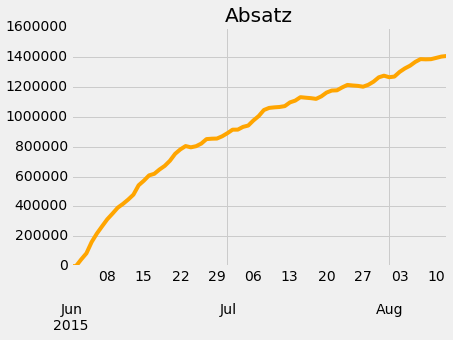

In [5]:

gameOwner["owner"].plot(style="orange")

plt.title( "Absatz")

In [6]:
absatz = [0,]
for x in range(1,len(gameOwner)):
    absatzT = gameOwner["owner"][x]-gameOwner["owner"][x-1]
    absatz.append(absatzT)

In [7]:
gameOwner["absatz"] = absatz
gameOwner["kum. absatz"] = gameOwner["owner"]

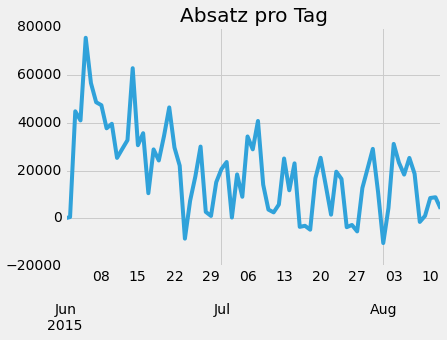

In [8]:
gameOwner["absatz"].plot(title= "Absatz pro Tag")

C:\Users\Janis\Anaconda2\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


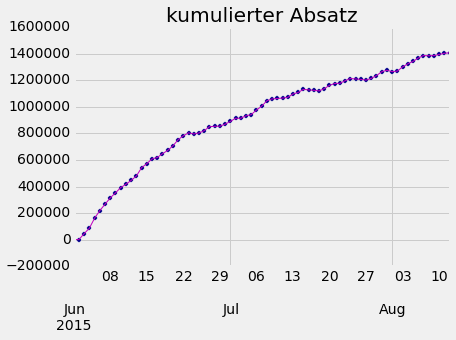

In [9]:
gameOwner["kum. absatz"].plot(color = "m", lw = 1)
plt.scatter(gameOwner.index, gameOwner["kum. absatz"], c="darkblue" , s = 20)
plt.title("kumulierter Absatz")


<h4> Moving Average?
Sehr volatile Daten, z.T. negativer Absatz. <h4>

In [10]:
gameOwner["kum. absatz"] = pd.ewma(gameOwner["kum. absatz"] ,2)
gameOwner["absatz"] = pd.ewma( gameOwner["absatz"] , 2)

In [11]:
linRegData = pd.DataFrame()
linRegData["absatz"] = gameOwner["absatz"]
linRegData["N"] = gameOwner["kum. absatz"]
linRegData["N**2"] = (gameOwner["kum. absatz"]**2)

Schätzung nur bis zum 1. August.<br>
Erlaubt es die Prediction mit den Realverkäufen ab 1.August zu vergleichen

In [12]:
linRegData = linRegData.ix[:"2015-08-01"]

In [13]:
linRegData = linRegData.reset_index()


In [14]:
linRegData.head()

,index,absatz,N,N**2
0,2015-06-01,0.000000,0.000000,0.000000e+00
1,2015-06-02,328.200000,328.200000,1.077152e+05
2,2015-06-03,21398.052632,21657.157895,4.690325e+08
3,2015-06-04,29533.753846,48525.415385,2.354716e+09
4,2015-06-05,47199.909953,92045.672986,8.472406e+09


In [15]:
linearRegression = linear_model.LinearRegression()
linearRegression.fit(linRegData[["N", "N**2"]].values, linRegData["absatz"].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [16]:
linearRegression.intercept_,    linearRegression.coef_

(29636.689444840238, array([  2.12445212e-02,  -3.38041223e-08]))

In [17]:
###Alternative Regressions Modul
import statsmodels.api as sm
regX_axis = sm.add_constant(linRegData[["N", "N**2"]].values, prepend = False)
regY_axis =  linRegData["absatz"].values
ols_regression = sm.OLS(regY_axis, regX_axis).fit()
#ols_regression.summary()

# Es gibt Zwei Formeln um Bass zu schaetzen:

Aus den ME Folien:
<p><p>
m MUSS bekannt sein <p>
p = beta0/m <p>
q = -beta2 * m

# und die zweite Formel:
und aus https://www.youtube.com/watch?v=3QoZn9mxjjs
<p><p>
m = (-beta1 +- sqr(beta1**2-4*beta0*beta2)/(2*beta2) <p>
p = beta0/m <p>
q = beta1 + beta0/m

In [18]:
#T = anzahl der zu schaetzenden Perioden
T = 100

b0 = linearRegression.intercept_
b1 =  linearRegression.coef_[0]
b2 =  linearRegression.coef_[1]
b0, b1, b2

(29636.689444840238, 0.021244521237253285, -3.3804122255632461e-08)

In [19]:
m = (-b1- sqrt(b1**2-(4*b0*b2))) /( 2 * b2)
m

1301882.787252367

In [20]:
p2 = b0/m
#q2 = b1 + (b0/m)
q2 = -b2*m

print "p:", p2, " und q: ", q2

p: 0.0227644836655  und q:  0.0440090049028


In [21]:
predictionQt2 = [0,]
predictionN2 = [0,]

for i in range(0,T):
    N = predictionN2[i]
    adoptorenT = (p2*m)+(q2-p2)*N + (-q2/m) * N**2
    adoptorenT = (p2*m)+(q2-p2)*N+(-q2/m)*(N**2)
    adoptorenT = round(adoptorenT, 2)
    predictionQt2.append(adoptorenT)
    predictionN2.append((predictionN2[i]+adoptorenT))

In [22]:
bassDF = pd.DataFrame(index=pd.date_range('6/2/2015', periods=101, freq='d'))
bassDF["Prediction_Absatz"]  = predictionQt2
bassDF["Prediction_kum. Absatz"]  = predictionN2
gameOwner = bassDF.join(gameOwner, how='outer')
gameOwner["diff_Absatz"] = gameOwner["Prediction_Absatz"] - gameOwner["absatz"]

Vergleich der predition mit den tatsaechlichen zahlen

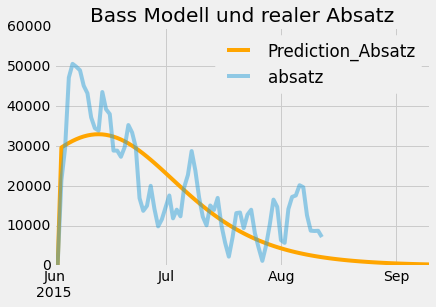

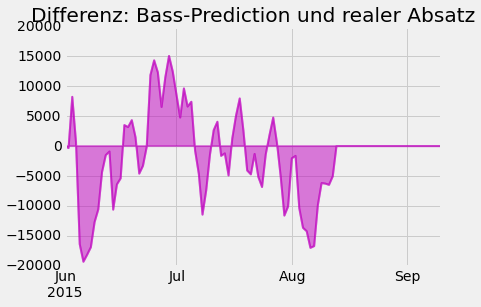

In [23]:
gameOwner["Prediction_Absatz"].plot(color ="orange")
gameOwner["absatz"].plot(alpha = 0.5)
plt.title("Bass Modell und realer Absatz")
plt.legend()
plt.figure()
gameOwner["diff_Absatz"] .plot(kind = "area", stacked = False, lw = 2, color = "m", linestyle = "-")
plt.title("Differenz: Bass-Prediction und realer Absatz")
#gameOwner["diff_Absatz"] .plot(kind = "area",secondary_y = True, stacked = False, alpha = 0.24)


Prediction fuer die kommenden Tage:

In [24]:
gameOwner["Prediction_Absatz"].loc["2015-07-06": "2015-07-11"]

2015-07-06    18938.59
2015-07-07    18101.41
2015-07-08    17278.57
2015-07-09    16472.47
2015-07-10    15685.18
2015-07-11    14918.48
Name: Prediction_Absatz, dtype: float64

In [25]:
#Neusten Zahlen auf Steamspy
steamSpyUpdate = [34281, 23791,34130, 27163, 19721, 6481, 3989, 10866]
steamSpyPriceUpdate = [24.89,24.89,24.89, 29.99,29.99,29.99,29.99,29.99,]
steamSpyUpdate = gameOwner.ix["2015-08-01":]
gameOwner["updateSales"] = steamSpyUpdate["absatz"]


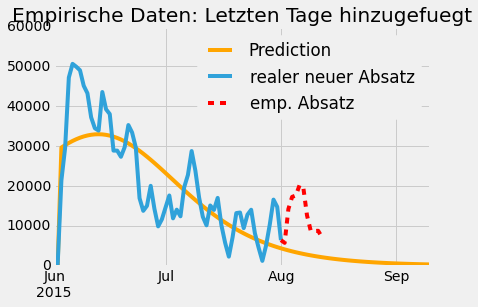

In [26]:
gameOwner["Prediction_Absatz"].plot(color ="orange")

gameOwner.ix[:"2015-08-01", "absatz"].plot()
gameOwner["updateSales"].plot(color = "red", linestyle="--")
plt.legend(["Prediction", "realer neuer Absatz", "emp. Absatz"])
plt.title("Empirische Daten: Letzten Tage hinzugefuegt")
plt.show()



## Ergenis:<p>
- Absatz wird unterschätzt.
- Grundsätzlich ist das Bass Modell anwendbar auf PC Spiele, denn sie passen in die Bass limitationen (nur einmal käufe, idealerweise verbreiten sie sich mithilfe von Innovatoren und Immitatoren)
- Dennoch greifen auch hier klassische Bass einschränkungen (ignoriert den Preis, ignoriert Wettbewerber/andere Spiele)